## Importacion de librerias

In [1]:
ga_update = 1

In [2]:
if ga_update:
  !pip install deap
  !pip install --upgrade scikit-learn==0.23.2
  !git clone https://github.com/senolakkas/sklearn-optimize
  !mv sklearn-optimize/ sklearn_genetic/

     |████████████████████████████████| 163kB 5.3MB/s 
     |████████████████████████████████| 6.8MB 5.1MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
Cloning into 'sklearn-optimize'...
remote: Enumerating objects: 29, done.
remote: Total 29 (delta 0), reused 0 (delta 0), pack-reused 29
Unpacking objects: 100% (29/29), done.


In [3]:
import os
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold
from scipy.io import arff
import random
from collections import OrderedDict
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import plot_precision_recall_curve

from deap import base, creator, tools, algorithms
from sklearn.base import clone, is_classifier

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

## sklearn-optimize es tomado de: https://github.com/senolakkas/sklearn-optimize
from sklearn_genetic.genetic import GeneticSearchCV

import joblib

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.metrics import confusion_matrix
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Leer dataset imputado

In [5]:
# se carga dataset imputado
median_imputed_df = pd.read_pickle('dataset_normalizado.pkl')

In [6]:
# función para separar las columnas en variables y etiquetas ('flag')
def split_features_labels(df):
    feature_dfs = df.iloc[:, :-1]
    label_dfs = df['flag']
    return feature_dfs, label_dfs

## Estrategia de validacion

In [7]:
# Validación cruzada mediante K-fold estratificado
def kfold_cv(k, X, y, verbose=False):
    X = X.values  # Variables
    y = y.values  # Etiquetas
    kf = StratifiedKFold(n_splits=k, shuffle=False, random_state=42)
    # inicializamos los sets vacios
    X_train = [] 
    y_train = []
    X_test = []
    y_test = []
    # usamos el split 
    for train_index, test_index in kf.split(X,y):
        X_train.append(X[train_index])
        y_train.append(y[train_index])
        X_test.append(X[test_index])
        y_test.append(y[test_index])
    return X_train, y_train, X_test, y_test
# seteamos la semilla para tener valores random predecibles
seed = 7

In [8]:
# Modelamiento de la data usando un diccionario de datasets y modelos
def perform_data_modeling(_models_, imputed_df, verbose=False, k_folds=5):
    # 7 metricas, usando K-Folds
    # en model_results guardaremos los resultados por clasificador y datasets
    model_results = OrderedDict()

    # Iteramos sobre los clasificadores
    for model_name, clf in _models_.items():
        if verbose: print("-" * 120, "\n", "Model: " + '\033[1m' + model_name + '\033[0m' + " Classifier")
        imputer_results = OrderedDict()

        # hacemos la division del dataframe en variables y etiquetas
        features_df, labels_df = split_features_labels(imputed_df)

        df_index = 0
        if verbose: print('\t\tDataset: ' + '\033[1m' + str(df_index + 1) + 'year' + '\033[0m')
        # Ejecutamos la validación cruzada K-fold en los sets de entranamiento y test
        X_train_list, y_train_list, X_test_list, y_test_list = kfold_cv(k_folds, features_df, labels_df, verbose)

        metrics = OrderedDict()

        # incializamos las metricas a guardar
        accuracy_list = np.zeros([k_folds])
        precision_list = np.zeros([k_folds, 2])
        recall_list = np.zeros([k_folds, 2])
        true_negs = np.zeros([k_folds])
        false_pos = np.zeros([k_folds])
        false_negs = np.zeros([k_folds])
        true_pos = np.zeros([k_folds])
        auc_list = np.zeros([k_folds])

        # Iteramos sobre los k-folds para el cálculo de las métricas
        for k in range(k_folds):
            X_train = X_train_list[k]
            y_train = y_train_list[k]
            X_test = X_test_list[k]
            y_test = y_test_list[k]

            # Fit del modelo 
            clf = clf.fit(X_train, y_train)
            # y predicción en el set de test
            y_test_predicted = clf.predict(X_test)
            # presentamos la matriz de confusión
            print(confusion_matrix(y_test_predicted, y_test))

            # guardamos accuracy y recall
            _accuracy_ = accuracy_score(y_test, y_test_predicted, normalize=True)
            accuracy_list[k] = _accuracy_
            _recalls_ = recall_score(y_test, y_test_predicted, average=None)
            recall_list[k] = _recalls_

            # guardamos precision
            _precisions_ = precision_score(y_test, y_test_predicted, average=None)
            precision_list[k] = _precisions_

            # calculamos la matriz de confusión
            _confusion_matrix_ = confusion_matrix(y_test, y_test_predicted)
            mlp_cm = confusion_matrix(y_test, y_test_predicted)

            # calculamos el auc
            _auc_curve_ = roc_auc_score(y_test, y_test_predicted)

            # guardamos demás valores: TN, FP, FN, TP
            true_negs[k] = _confusion_matrix_[0][0]
            false_pos[k] = _confusion_matrix_[0][1]
            false_negs[k] = _confusion_matrix_[1][0]
            true_pos[k] = _confusion_matrix_[1][1]

            # guardamos roc
            auc_list[k] = _auc_curve_

        # Hacemos la media en el caso de más datasets
        metrics['Accuracy'] = np.mean(accuracy_list)
        metrics['Precisions'] = np.mean(precision_list, axis=0)
        metrics['Recalls'] = np.mean(recall_list, axis=0)
        metrics['TN'] = np.mean(true_negs)
        metrics['FP'] = np.mean(false_pos)
        metrics['FN'] = np.mean(false_negs)
        metrics['TP'] = np.mean(true_pos)
        metrics['AUC'] = np.mean(auc_list)

        # presentamos algunos valores
        if verbose:
            print('\t\t\tAccuracy:', metrics['Accuracy'])
            print('\t\t\tRecall:', metrics['Recalls'])

        # guardamos en el diccionario
        model_results[model_name] = metrics

    # presentamos la matriz de confusión en modo mapa de calor
    sns.heatmap(mlp_cm, annot=True,
                xticklabels=['Non Bankrupt', 'Bankrupt'],
                yticklabels=['Non Bankrupt', 'Bankrupt'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return model_results


In [9]:
# Hacer ranking por cada métrica
def perform_model_ranking_acc(models, imputers, results):
    column_headers = ['-','Accuracy'] 
    rows = []
    for model_name, model_details in results.items():
        row = [model_name]
        row.append(model_details['Accuracy'])
        rows.append(row)
    results_df = pd.DataFrame(data=rows, columns = column_headers)
    return results_df

def perform_model_ranking_f1score(models, imputers, results):
    column_headers = ['-','F1-score']
    rows = []
    for model_name, model_details in results.items():
        row = [model_name]
        recall = model_details['Recalls']
        precision = model_details['Precisions']
        f1score = 2*(recall*precision)/(recall+precision)
        row.append(f1score)
        rows.append(row)
    results_df = pd.DataFrame(data=rows, columns = column_headers)
    return results_df

def perform_model_ranking_auc(models, imputers, results):
    column_headers = ['-','AUC']
    rows = []
    for model_name, model_details in results.items():
        row = [model_name]
        row.append(model_details['AUC'])
        rows.append(row)
    results_df = pd.DataFrame(data=rows, columns = column_headers)
    return results_df

def perform_model_ranking_typeI(models, imputers, results):
    column_headers = ['-','FP']
    rows = []
    for model_name, model_details in results.items():
        row = [model_name]
        row.append(model_details['FP'])
        rows.append(row)
    results_df = pd.DataFrame(data=rows, columns = column_headers)
    return results_df

## Modelos SVM y SVM+GA

**Hyperparámetros para ajuste**

In [10]:
param = {'kernel': ['rbf'],
          'C': [0, 100], 
          'gamma': [0.01, 0.001]}
param_ga = {"kernel": ["rbf", "sigmoid", "linear"],
             "C": np.logspace(-2, 2, num=10, base=10),
             "gamma": np.logspace(-2, 2, num=10, base=10)}

**Separamos las variables y etiquetas**

In [11]:
X, y = split_features_labels(median_imputed_df) 

**Ahora se hará la búsqueda, si no desea esperar poner 'load' a 1!**

In [12]:
load = 0

In [13]:
# svm búsqueda simple
cv_svm = GridSearchCV(estimator=SVC(probability=True), 
                      param_grid=param,
                      scoring="accuracy",
                      cv=5)
if load==0:
  cv_svm.fit(X, y)

In [14]:
cv_svm.best_estimator_

SVC(C=100, gamma=0.001, probability=True)

In [15]:
# GeneticSearchCV modificado
class GeneticSearchCVMod(GeneticSearchCV):
     def __init__(self, estimator, params, scoring=None, cv=4,
                 refit=True, verbose=False, population_size=50,
                 gene_mutation_prob=0.1, gene_crossover_prob=0.5,
                 tournament_size=3, generations_number=10, gene_type=None,
                 n_jobs=1, iid=True, error_score='raise',
                 fit_params={}):
        super(GeneticSearchCV, self).__init__(
            estimator=estimator, scoring=scoring,
            iid=iid, refit=refit, cv=cv, verbose=verbose,
            error_score=error_score)
        self.fit_params=fit_params
        self.params = params
        self.population_size = population_size
        self.generations_number = generations_number
        self._individual_evals = {}
        self.gene_mutation_prob = gene_mutation_prob
        self.gene_crossover_prob = gene_crossover_prob
        self.tournament_size = tournament_size
        self.gene_type = gene_type
        self.all_history_, self.all_logbooks_ = [], []
        self._cv_results = None
        self.best_score_ = None
        self.best_params_ = None
        self.score_cache = {}
        self.n_jobs = n_jobs
        creator.create("FitnessMax", base.Fitness, weights=(1.0,))
        creator.create("Individual", list, est=clone(self.estimator), fitness=creator.FitnessMax)

In [16]:
# svm + ga
cv_svm_ga = GeneticSearchCVMod(estimator=SVC(probability=True),
                     params=param_ga,
                     scoring="recall",
                     cv=StratifiedKFold(n_splits=4),
                     verbose=1,
                     population_size=20,
                     gene_mutation_prob=0.10,
                     gene_crossover_prob=0.5,
                     tournament_size=3,
                     generations_number=5,
                     n_jobs=4)
if load == 0:
  cv_svm_ga.fit(X, y)

Types [1, 2, 2] and maxint [2, 9, 9] detected
--- Evolve in 300 possible combinations ---
gen	nevals	avg      	min	max     	std      
0  	20    	0.0463646	0  	0.199989	0.0509942
1  	12    	0.086137 	0  	0.199989	0.0582341
2  	12    	0.13     	0  	0.199989	0.0574257
3  	9     	0.168858 	0.0863603	0.200005	0.0447933
4  	18    	0.186128 	0.0863603	0.200005	0.0336034
5  	7     	0.181362 	0.0545481	0.200005	0.0447417
Best individual is: {'kernel': 'rbf', 'C': 12.915496650148826, 'gamma': 0.027825594022071243}
with fitness: 0.20000533269341011


In [17]:
# guardamos los grid-searchs para ahorrar tiempo en futuras ejecuciones
joblib.dump(cv_svm, 'Modelo_SVM.pkl')
joblib.dump(cv_svm_ga, 'Modelo_GA_SVM.pkl')

['Modelo_GA_SVM.pkl']

In [18]:
# cargamos los grid-searchs guardados
cv_svm = joblib.load('Modelo_SVM.pkl')
cs_svm_ga = joblib.load('Modelo_GA_SVM.pkl')

In [19]:
cs_svm_ga.best_estimator_

SVC(C=12.915496650148826, gamma=0.027825594022071243, probability=True)

In [20]:
svm = cv_svm.best_estimator_
svm_ga = cs_svm_ga.best_estimator_
models_dictionary2 = OrderedDict()
models_dictionary2['SVM'] = svm
models_dictionary2['SVM+GA'] = svm_ga

------------------------------------------------------------------------------------------------------------------------ 
 Model: SVM Classifier
		Dataset: 1year
[[1318   43]
 [   2    1]]
[[1262   42]
 [  58    2]]
[[1319   41]
 [   1    3]]
[[1319   38]
 [   1    6]]
[[1318   39]
 [   1    5]]
			Accuracy: 0.9609927643653059
			Recall: [0.99045443 0.07727273]
------------------------------------------------------------------------------------------------------------------------ 
 Model: SVM+GA Classifier
		Dataset: 1year
[[1284   31]
 [  36   13]]
[[1238   39]
 [  82    5]]
[[1315   38]
 [   5    6]]
[[1308   35]
 [  12    9]]
[[1313   37]
 [   6    7]]
			Accuracy: 0.9529279255050207
			Recall: [0.97863567 0.18181818]


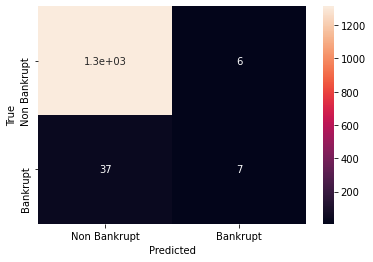

In [21]:
# Cross validación con 5 sets
results2 = perform_data_modeling(models_dictionary2, median_imputed_df, verbose=True, k_folds=5)

In [22]:
print(perform_model_ranking_acc(models_dictionary2, median_imputed_df, results2))
print(perform_model_ranking_f1score(models_dictionary2, median_imputed_df, results2))
print(perform_model_ranking_auc(models_dictionary2, median_imputed_df, results2))
print(perform_model_ranking_typeI(models_dictionary2, median_imputed_df, results2))

        -  Accuracy
0     SVM  0.960993
1  SVM+GA  0.952928
        -                                   F1-score
0     SVM  [0.9800497632444028, 0.13584790565270435]
1  SVM+GA   [0.975742441527818, 0.24317876430269617]
        -       AUC
0     SVM  0.533864
1  SVM+GA  0.580227
        -    FP
0     SVM  12.6
1  SVM+GA  28.2


In [23]:
def update_resultados(descripcion, model, resultados, X_train, X_test, y_train, y_test):
  y_train_pred = model.predict(X_train)
  y_train_pred_proba = model.predict_proba(X_train)[:,1]

  y_test_pred = model.predict(X_test)
  y_test_pred_proba = model.predict_proba(X_test)[:,1]

  resultados.update( { descripcion: {
      ('Entrenamiento', 'Exactitud'): model.score(X_train, y_train),
      ('Entrenamiento', 'Precisión'): precision_score(y_train, y_train_pred, zero_division=0),
      ('Entrenamiento', 'Exhaustividad'): recall_score(y_train, y_train_pred),
      ('Entrenamiento', 'F1'): f1_score(y_train, y_train_pred),
      ('Entrenamiento', 'AUC'): roc_auc_score(y_train, y_train_pred_proba),
      ('Pruebas', 'Exactitud'): model.score(X_test, y_test),
      ('Pruebas', 'Precisión'): precision_score(y_test, y_test_pred, zero_division=0),
      ('Pruebas', 'Exhaustividad'): recall_score(y_test, y_test_pred),
      ('Pruebas', 'F1'): f1_score(y_test, y_test_pred),
      ('Pruebas', 'AUC'): roc_auc_score(y_test, y_test_pred_proba)
    } } )
  display(pd.DataFrame.from_dict(resultados, orient='index'))

  fig, axes = plt.subplots(1, 3, figsize=(18, 5))
  fig.suptitle(f'{descripcion} (Conjunto de Pruebas)')
  plot_confusion_matrix(model, X_test, y_test, ax=axes[0], values_format='d')
  plot_roc_curve(model, X_test, y_test, ax=axes[1], name=descripcion)
  plot_precision_recall_curve(model, X_test, y_test, ax=axes[2], name=descripcion)
  return

In [24]:
# Modelamiento de la data usando un diccionario de datasets y modelos
def perform_data_evaluation(_models_, imputed_df, verbose=False, k_folds=5):
    # 7 metricas, usando K-Folds
    # en model_results guardaremos los resultados por clasificador y datasets
    model_results = OrderedDict()
    # to show table
    resultados = {}

    # Iteramos sobre los clasificadores
    for model_name, clf in _models_.items():
        imputer_results = OrderedDict()

        # hacemos la division del dataframe en variables y etiquetas
        features_df, labels_df = split_features_labels(imputed_df)

        df_index = 0
        # Ejecutamos la validación cruzada K-fold en los sets de entranamiento y test
        X_train_list, y_train_list, X_test_list, y_test_list = kfold_cv(k_folds, features_df, labels_df, verbose)

        metrics = OrderedDict()

        # incializamos las metricas a guardar
        accuracy_list = np.zeros([k_folds])
        precision_list = np.zeros([k_folds, 2])
        recall_list = np.zeros([k_folds, 2])
        true_negs = np.zeros([k_folds])
        false_pos = np.zeros([k_folds])
        false_negs = np.zeros([k_folds])
        true_pos = np.zeros([k_folds])
        auc_list = np.zeros([k_folds])

        # Iteramos sobre los k-folds para el cálculo de las métricas
        for k in range(k_folds):
            X_train = X_train_list[k]
            y_train = y_train_list[k]
            X_test = X_test_list[k]
            y_test = y_test_list[k]

            # y predicción en el set de test
            y_test_predicted = clf.predict(X_test)

            # guardamos accuracy y recall
            _accuracy_ = accuracy_score(y_test, y_test_predicted, normalize=True)
            accuracy_list[k] = _accuracy_
            _recalls_ = recall_score(y_test, y_test_predicted, average=None)
            recall_list[k] = _recalls_

            # guardamos precision
            _precisions_ = precision_score(y_test, y_test_predicted, average=None)
            precision_list[k] = _precisions_

            # calculamos la matriz de confusión
            _confusion_matrix_ = confusion_matrix(y_test, y_test_predicted)
            mlp_cm = confusion_matrix(y_test, y_test_predicted)

            # guardamos demás valores: TN, FP, FN, TP
            true_negs[k] = _confusion_matrix_[0][0]
            false_pos[k] = _confusion_matrix_[0][1]
            false_negs[k] = _confusion_matrix_[1][0]
            true_pos[k] = _confusion_matrix_[1][1]

            # calculamos el auc
            _auc_curve_ = roc_auc_score(y_test, y_test_predicted)
            # guardamos auc
            auc_list[k] = _auc_curve_

        # Hacemos la media en el caso de más datasets
        metrics['Accuracy'] = np.mean(accuracy_list)
        metrics['Precisions'] = np.mean(precision_list, axis=0)
        metrics['Recalls'] = np.mean(recall_list, axis=0)
        metrics['TN'] = np.mean(true_negs)
        metrics['FP'] = np.mean(false_pos)
        metrics['FN'] = np.mean(false_negs)
        metrics['TP'] = np.mean(true_pos)
        metrics['AUC'] = np.mean(auc_list)

        # presentamos algunos valores
        if verbose:
            update_resultados(model_name, clf, resultados, X_train, X_test, y_train, y_test)

        # guardamos en el diccionario
        model_results[model_name] = metrics

    return model_results

Entrenamiento                          ...       Pruebas               
        Exactitud Precisión Exhaustividad  ... Exhaustividad   F1       AUC
SVM      0.973424  0.942857        0.1875  ...      0.113636  0.2  0.904439

[1 rows x 10 columns]

Entrenamiento                          ...       Pruebas                    
           Exactitud Precisión Exhaustividad  ... Exhaustividad        F1       AUC
SVM         0.973424  0.942857      0.187500  ...      0.113636  0.200000  0.904439
SVM+GA      0.992119  1.000000      0.755682  ...      0.159091  0.245614  0.926959

[2 rows x 10 columns]

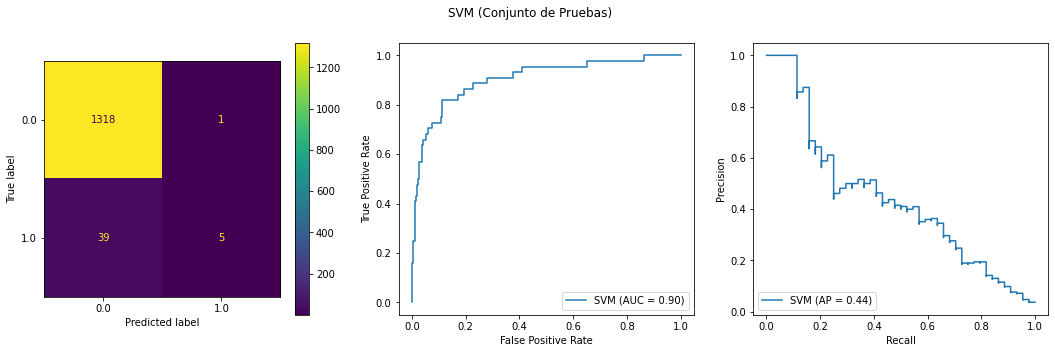

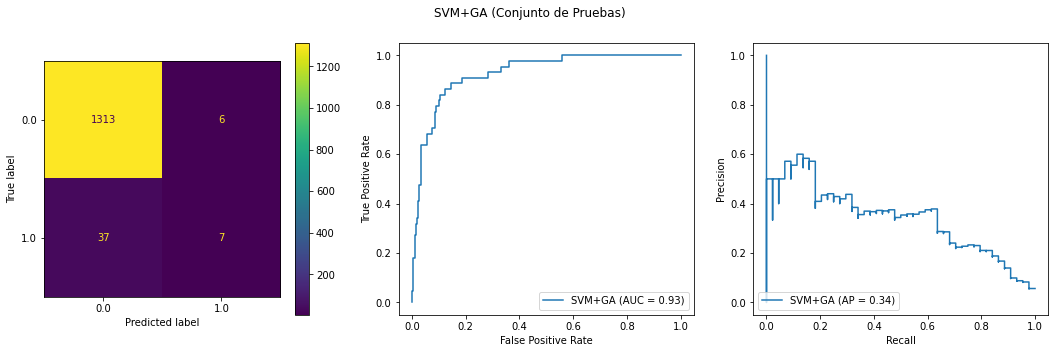

In [25]:
# Cross validación con 5 sets
results3 = perform_data_evaluation(models_dictionary2, median_imputed_df, verbose=True, k_folds=5)